# **Desafio**

**Previsão de uso de metrô por estação de NYC em 2015**

**Variáveis disponíveis:**

**CA** = *Área de Controle (A002)*

**UNIT** = *Unidade Remota para uma estação (R051)*

**SCP** = *Subunit Channel Position representa um endereço específico para um dispositivo (02-00-00)*

**STATION** = *Representa o nome da estação em que o dispositivo está localizado*

**LINENAME** = *Representa todas as linhas de trem que podem ser embarcadas nesta estação Normalmente as linhas são representadas por um caractere. 
LINENAME 456NQR representa o servidor de trem para trens 4, 5, 6, N, Q e R.* 

**DIVISION** = *Representa a Linha originalmente a estação pertencia ao BMT, IRT ou IND*

**DATE** = *Representa a data (MM-DD-YY) TIME = Representa a hora (hhmmss) para um evento de auditoria agendado*

**DESC** = *Representa o evento de auditoria agendado REGULAR (normalmente ocorre a cada 4 horas) 1. As auditorias podem ocorrer mais de 4 horas devido para atividades de planejamento ou solução de problemas. 2. Além disso, pode haver uma entrada RECOVR AUD Isso se refere a uma auditoria perdida que foi recuperada.* 

**ENTRIES** = *O valor do registro de entrada cumulativo para um dispositivo*

**EXITS** = *O valor do registro de saída cumulativo para um dispositivo*


# **Bibliotecas utilizadas**

In [1]:
import pandas as pd
import numpy as np
import holidays
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet

# **Conhecendo e adequando o dataframe**

In [2]:
#Importando e observando as primeiras 5 linhas de dados. (verificar se carregou corretamente)
bd_2015 = pd.read_csv('drive/MyDrive/2015.csv')
bd_2015.head(5)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2015-01-01 00:00:00,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,4943145.0,1674709.0
1,2015-01-01 00:00:00,A002,R051,02-00-01,LEXINGTON AVE,NQR456,BMT,REGULAR,4593083.0,1001645.0
2,2015-01-01 00:00:00,A002,R051,02-03-00,LEXINGTON AVE,NQR456,BMT,REGULAR,425709.0,1599459.0
3,2015-01-01 00:00:00,A002,R051,02-03-01,LEXINGTON AVE,NQR456,BMT,REGULAR,4535415.0,7113382.0
4,2015-01-01 00:00:00,A002,R051,02-03-02,LEXINGTON AVE,NQR456,BMT,REGULAR,4269557.0,5862230.0


In [3]:
#Verificando tipos de variáveis.
bd_2015.dtypes

time         object
ca           object
unit         object
scp          object
station      object
linename     object
division     object
desc         object
entries     float64
exits       float64
dtype: object

In [4]:
#Conhecendo a diversidade de estações e centros presentes no dataframe.
print(bd_2015['station'].value_counts(), '\n ---------------')
print(bd_2015['scp'].value_counts(), '\n ---------------')
print(bd_2015['ca'].value_counts(), '\n ---------------')

34 ST-PENN STA     223818
FULTON ST          211391
42 ST-GRD CNTRL    136430
CANAL ST           127954
34 ST-HERALD SQ    121240
                    ...  
182-183 STS           102
BUSHWICK AV           102
WILSON AV             102
CORTELYOU RD          102
SUTTER AV              70
Name: station, Length: 567, dtype: int64 
 ---------------
00-00-00    1008292
00-00-01    1003778
00-00-02     912175
00-00-03     432438
00-03-00     321269
             ...   
00-03-0B        701
00-D2-01          1
00-51-02          1
01-55-06          1
00-00-B7          1
Name: scp, Length: 219, dtype: int64 
 ---------------
PTH08    55280
PTH05    53345
R610     49153
R238     46494
PTH16    45683
         ...  
OB01      3682
A085      2190
PTH21     2084
R629      2001
R633      2001
Name: ca, Length: 731, dtype: int64 
 ---------------


In [5]:
#Verificando se há informações duplicadas.
print(bd_2015.shape, 'antes')
bd_2015 = bd_2015.drop_duplicates()
print(bd_2015.shape, 'depois')

(10055314, 10) antes
(10055314, 10) depois


In [6]:
#Verificando se há informações nulas.
bd_2015.isnull().sum()

time        0
ca          0
unit        0
scp         0
station     0
linename    0
division    0
desc        0
entries     0
exits       0
dtype: int64

In [7]:
#Como podemos observar, não há linhas com informações nulas, caso houvesse,  verificaríamos da seguinte forma.
nulas = bd_2015[bd_2015.isnull().any(axis=1)]
print(nulas)

Empty DataFrame
Columns: [time, ca, unit, scp, station, linename, division, desc, entries, exits]
Index: []


Achei os valores de entradas e saídas muito alto, como diz ser cumulativo, peguei uma amostra pra ver se eles se acumulam na station e scp.

In [8]:
bd_2015[(bd_2015['station']=='LEXINGTON AVE') & (bd_2015['scp']=='02-00-00')].head(7)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2015-01-01 00:00:00,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,4943145.0,1674709.0
4571,2015-01-01 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,4943320.0,1674736.0
9106,2015-01-01 08:00:00,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,4943391.0,1674749.0
13643,2015-01-01 12:00:00,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,4943411.0,1674765.0
18394,2015-01-01 16:00:00,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,4943457.0,1674815.0
22927,2015-01-01 20:00:00,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,4943574.0,1674858.0
27466,2015-01-02 00:00:00,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,REGULAR,4943819.0,1674906.0


Como podemos ver, eles se acumulam mesmo, pra saber a real entrada e saída, devo subtrair do valor contabilizado anteriormente.

Antes de realizar a subtração, vou somar os valores de entrada e saída, assim vou ter a quantidade total de pessoas que utilizaram o metro.

In [9]:
#Criando variável data.
#Criando variável 'total_use' para o total de pessoas que utilizaram o metro (entrada + saida).
bd_2015['date'] = pd.to_datetime(bd_2015['time'].str[:10])
bd_2015['total_use'] = bd_2015['entries'] + bd_2015['exits']

In [10]:
#Agrupando em estação e data com somatório de entradas + saídas.
df = bd_2015.groupby(['date','station']).sum('total_use').sort_values('date',ascending=True)
df.reset_index(inplace=True)
df[df['station']=='LEXINGTON AVE'].head(5)

,date,station,entries,exits,total_use
31,2015-01-01,LEXINGTON AVE,461868909.0,350938551.0,812807460.0
410,2015-01-02,LEXINGTON AVE,461945781.0,351016739.0,812962520.0
792,2015-01-03,LEXINGTON AVE,462089330.0,351136308.0,813225638.0
1172,2015-01-04,LEXINGTON AVE,462184191.0,351245411.0,813429602.0
1553,2015-01-05,LEXINGTON AVE,462266094.0,351356556.0,813622650.0


In [11]:
#Criando variável de diferença entre o total do dia anterior.
df['total_use_ok'] = df['total_use'].diff()

#Com o cálculo de diferença a primeira informação fica nula, pois não há informação anterior para cálculo.
#Sendo assim, removi a primeira linha.
df.drop(0, inplace=True)
df.head(10)

,date,station,entries,exits,total_use,total_use_ok
1,2015-01-01,JAMAICA-VAN WYC,7.595611e+07,6.802315e+07,1.439793e+08,-4.696582e+08
2,2015-01-01,JAMAICA-179 ST,8.185323e+09,2.153293e+09,1.033862e+10,1.019464e+10
3,2015-01-01,JAMAICA CENTER,6.395654e+08,5.649287e+08,1.204494e+09,-9.134122e+09
4,2015-01-01,JACKSON AVE,7.467905e+07,1.725663e+07,9.193568e+07,-1.112558e+09
5,2015-01-01,INWOOD-207 ST,1.923063e+09,6.086771e+07,1.983930e+09,1.891995e+09
6,2015-01-01,INTERVALE-163,6.838958e+07,5.446778e+07,1.228574e+08,-1.861073e+09
7,2015-01-01,HUNTS POINT AVE,1.491478e+08,8.524059e+07,2.343884e+08,1.115310e+08
8,2015-01-01,HUNTERS PT AVE,1.259707e+10,5.142367e+09,1.773944e+10,1.750505e+10
9,2015-01-01,HUDSON-80 ST,9.778356e+07,8.410203e+07,1.818856e+08,-1.755755e+10
10,2015-01-01,HOYT/SCHERMER,1.651185e+08,1.708076e+08,3.359261e+08,1.540405e+08


Como podemos observar, a abordagem de subtração trouxe valores negativos, o que é estranho.

Mudarei a abordagem para a subtração do menor valor e maior, no dia. Isso deve corrigir contagem fora de ordem e diferenças onde os dias posteriores possuem valor acumulado inferior ao anterior.

Para essa abordagem, irei agrupar as informações de estação, ca, unit, scp e data. Assim consigo garantir que estou comparando dados do mesmo contador.

In [12]:
#Criando dfs com diferenças de valores de entrada e saída (mínimo e máximo) agrupado por 'station','ca','unit','scp','date'.
entradas = (bd_2015.groupby(['station','ca','unit','scp','date']).entries.max() - bd_2015.groupby(['station','ca','unit','scp','date']).entries.min()).reset_index()
saidas = (bd_2015.groupby(['station','ca','unit','scp','date']).exits.max() - bd_2015.groupby(['station','ca','unit','scp','date']).exits.min()).reset_index()

#verificando dimensões dos dfs gerados.
print('dimensões do df de entradas', entradas.shape)
print('dimensões do df de saídas', saidas.shape)

dimensões do df de entradas (1664365, 6)
dimensões do df de saídas (1664365, 6)


In [13]:
#Como possuem mesma quantidade de linhas, temos chances de todos os agrupamentos terem entrada e saída.
df_unificado = pd.merge(entradas, saidas, on = ['station','ca','unit','scp','date'],  how='inner')
df_unificado['total_use'] = df_unificado['entries'] + df_unificado['exits']
                                        
print('Conferindo dimensões do df_unificado', df_unificado.shape)

#Como possuem mesmo tamanho com inner join, sabemos que todos os grupos foram satisfeitos.
df_unificado.head(5)

Conferindo dimensões do df_unificado (1664365, 8)


,station,ca,unit,scp,date,entries,exits,total_use
0,1 AV,H007,R248,00-00-00,2015-12-26,806.0,1073.0,1879.0
1,1 AV,H007,R248,00-00-00,2015-12-27,1287.0,1765.0,3052.0
2,1 AV,H007,R248,00-00-00,2015-12-28,2056.0,2790.0,4846.0
3,1 AV,H007,R248,00-00-00,2015-12-29,2447.0,2835.0,5282.0
4,1 AV,H007,R248,00-00-00,2015-12-30,2483.0,3166.0,5649.0


In [14]:
#Verificando se há entradas ou saídas negativas.
print(df_unificado[df_unificado['entries']<0])
print(df_unificado[df_unificado['exits']<0])
print(df_unificado[df_unificado['total_use']<0])

Empty DataFrame
Columns: [station, ca, unit, scp, date, entries, exits, total_use]
Index: []
Empty DataFrame
Columns: [station, ca, unit, scp, date, entries, exits, total_use]
Index: []
Empty DataFrame
Columns: [station, ca, unit, scp, date, entries, exits, total_use]
Index: []


#**Análise Exploratória**

In [15]:
#Importando tabela de feirados dos EUA e incluindo informação no df base.
feriados = pd.DataFrame(holidays.US(years=[2015]).items(),columns=['date', 'holiday_name'])
feriados['date'] = pd.to_datetime(feriados['date'])
df_unificado = pd.merge(df_unificado, feriados, on = ['date'],  how='left')
df_unificado['holiday_dummy'] = np.where(df_unificado['holiday_name'].isnull()==True,0,1)
df_unificado.sort_values('holiday_name', ascending=True)

,station,ca,unit,scp,date,entries,exits,total_use,holiday_name,holiday_dummy
1664363,ZEREGA AVE,R419,R326,00-05-01,2015-12-25,0.0,0.0,0.0,Christmas Day,1
771566,BOWLING GREEN,R200A,R041,01-00-01,2015-12-25,194.0,80.0,274.0,Christmas Day,1
133920,161 ST-YANKEE,R262,R195,03-06-00,2015-12-25,266.0,49.0,315.0,Christmas Day,1
1261129,LACKAWANNA,PTH16,R550,01-02-00,2015-12-25,4.0,95.0,99.0,Christmas Day,1
771201,BOWLING GREEN,R200A,R041,01-00-00,2015-12-25,121.0,207.0,328.0,Christmas Day,1
...,...,...,...,...,...,...,...,...,...,...
1664359,ZEREGA AVE,R419,R326,00-05-01,2015-12-21,0.0,0.0,0.0,NaN,0
1664360,ZEREGA AVE,R419,R326,00-05-01,2015-12-22,0.0,0.0,0.0,NaN,0
1664361,ZEREGA AVE,R419,R326,00-05-01,2015-12-23,0.0,0.0,0.0,NaN,0
1664362,ZEREGA AVE,R419,R326,00-05-01,2015-12-24,0.0,0.0,0.0,NaN,0


In [16]:
#Incluindo informação do dia da semana e quinzena do mês.
df_unificado['date_day'] = df_unificado["date"].dt.day_name()
df_unificado['month'] = df_unificado['date'].dt.month 
df_unificado['half_month'] = np.where(df_unificado["date"].dt.day > 15, 1, 0)
df_unificado.head(5)

,station,ca,unit,scp,date,entries,exits,total_use,holiday_name,holiday_dummy,date_day,month,half_month
0,1 AV,H007,R248,00-00-00,2015-12-26,806.0,1073.0,1879.0,NaN,0,Saturday,12,1
1,1 AV,H007,R248,00-00-00,2015-12-27,1287.0,1765.0,3052.0,NaN,0,Sunday,12,1
2,1 AV,H007,R248,00-00-00,2015-12-28,2056.0,2790.0,4846.0,NaN,0,Monday,12,1
3,1 AV,H007,R248,00-00-00,2015-12-29,2447.0,2835.0,5282.0,NaN,0,Tuesday,12,1
4,1 AV,H007,R248,00-00-00,2015-12-30,2483.0,3166.0,5649.0,NaN,0,Wednesday,12,1


[Text(0, 0.5, 'Average usage'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average usage by month of all 2015 data')]

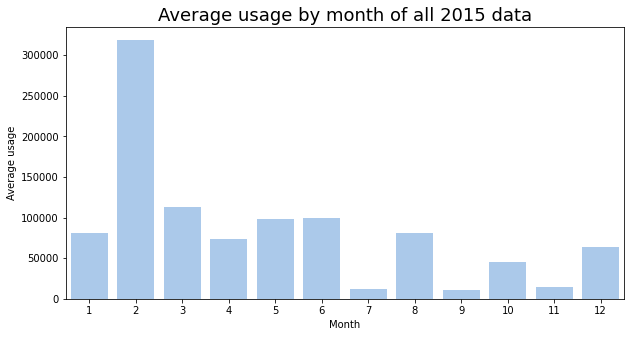

In [17]:
#Conhecendo o uso total por mês de todas as estações.
fig, axs = plt.subplots(figsize=(10, 5))

sns.set_context('talk')
sns.set_color_codes("pastel")

ax = sns.barplot(x="month", y="total_use",  data=df_unificado.groupby(['month']).total_use.mean().reset_index().sort_values("month", ascending=True) , color = 'b', label='Total', ci = None)
ax.set(xlabel="Month", ylabel = "Average usage", title='Average usage by month of all 2015 data')

Como podemos notar, há um pico em fevereiro e grandes baixas em julho e setembro e novembro.
Isso pode ser algum erro nas marcações de entradas e saídas.

Temos que tomar cuidado com esses outliers na hora da modelagem, pra não termos surpresas.

In [18]:
#Verificando dias em que mais temos feriados nos EUA.
holidays = df_unificado.groupby(['holiday_name', 'holiday_dummy', 'date_day']).total_use.mean().reset_index().sort_values("total_use", ascending=False)
print(holidays, '\n ---------------')
holidays['date_day'].value_counts()

                   holiday_name  holiday_dummy   date_day     total_use
5    Martin Luther King Jr. Day              1     Monday  23122.183080
10        Washington's Birthday              1     Monday   2682.995163
9                  Veterans Day              1  Wednesday   1511.245180
3   Independence Day (Observed)              1     Friday   1358.791914
1                  Columbus Day              1     Monday   1308.838477
7                New Year's Day              1   Thursday   1227.698420
4                     Labor Day              1     Monday    993.350099
6                  Memorial Day              1     Monday    851.651658
2              Independence Day              1   Saturday    834.648868
8                  Thanksgiving              1   Thursday    818.988669
0                 Christmas Day              1     Friday    598.334868 
 ---------------


Monday       5
Friday       2
Thursday     2
Wednesday    1
Saturday     1
Name: date_day, dtype: int64

Dos 11 feriados mapeados, 5 caem na segunda-feira

[Text(0, 0.5, 'Holiday Name'),
 Text(0.5, 0, 'Average usage'),
 Text(0.5, 1.0, 'Average usage by Holiday of all 2015 data')]

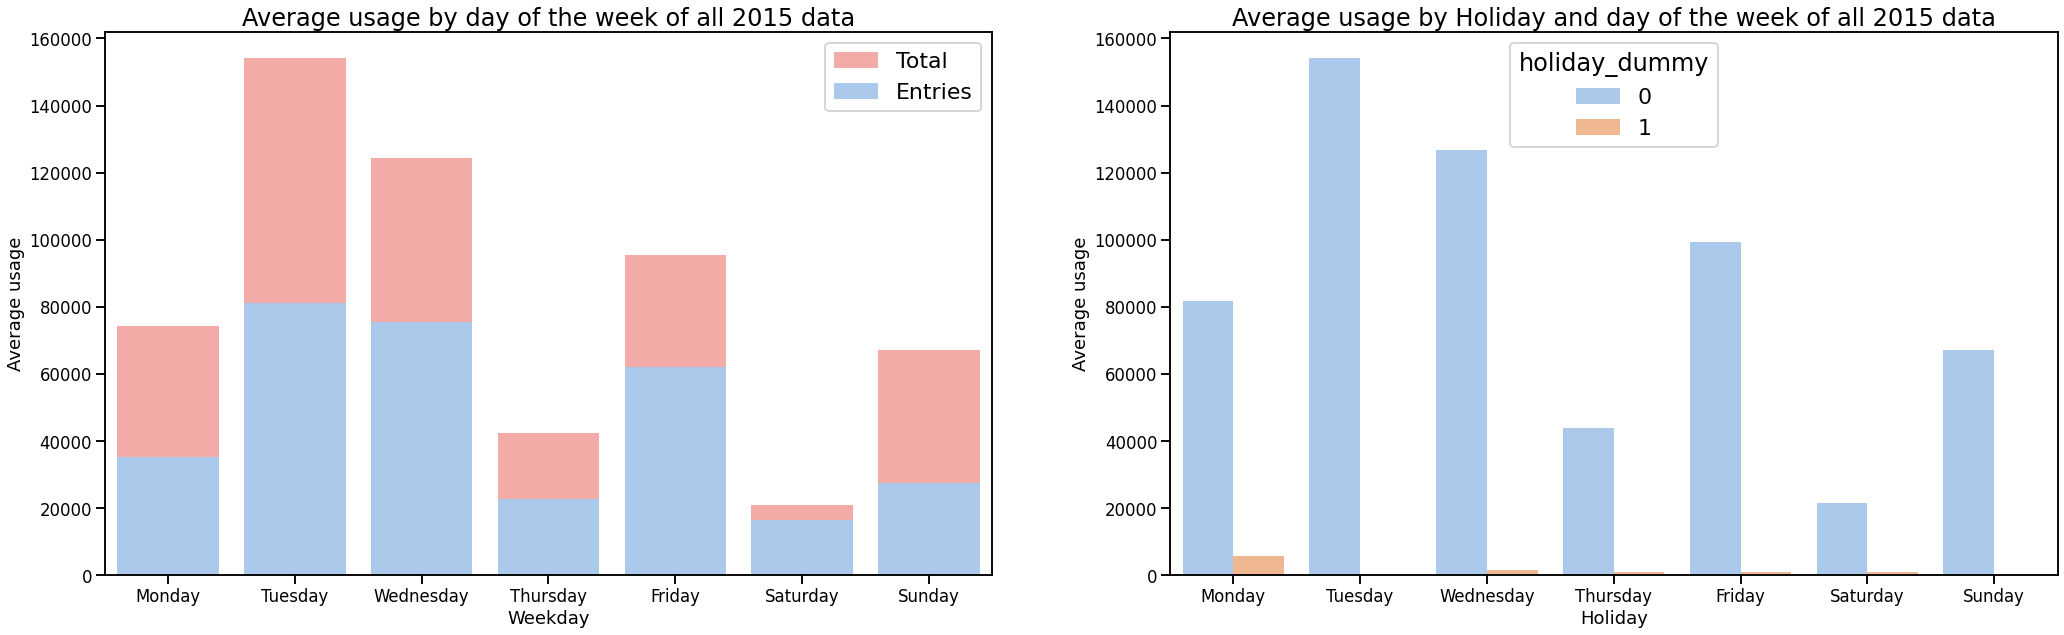

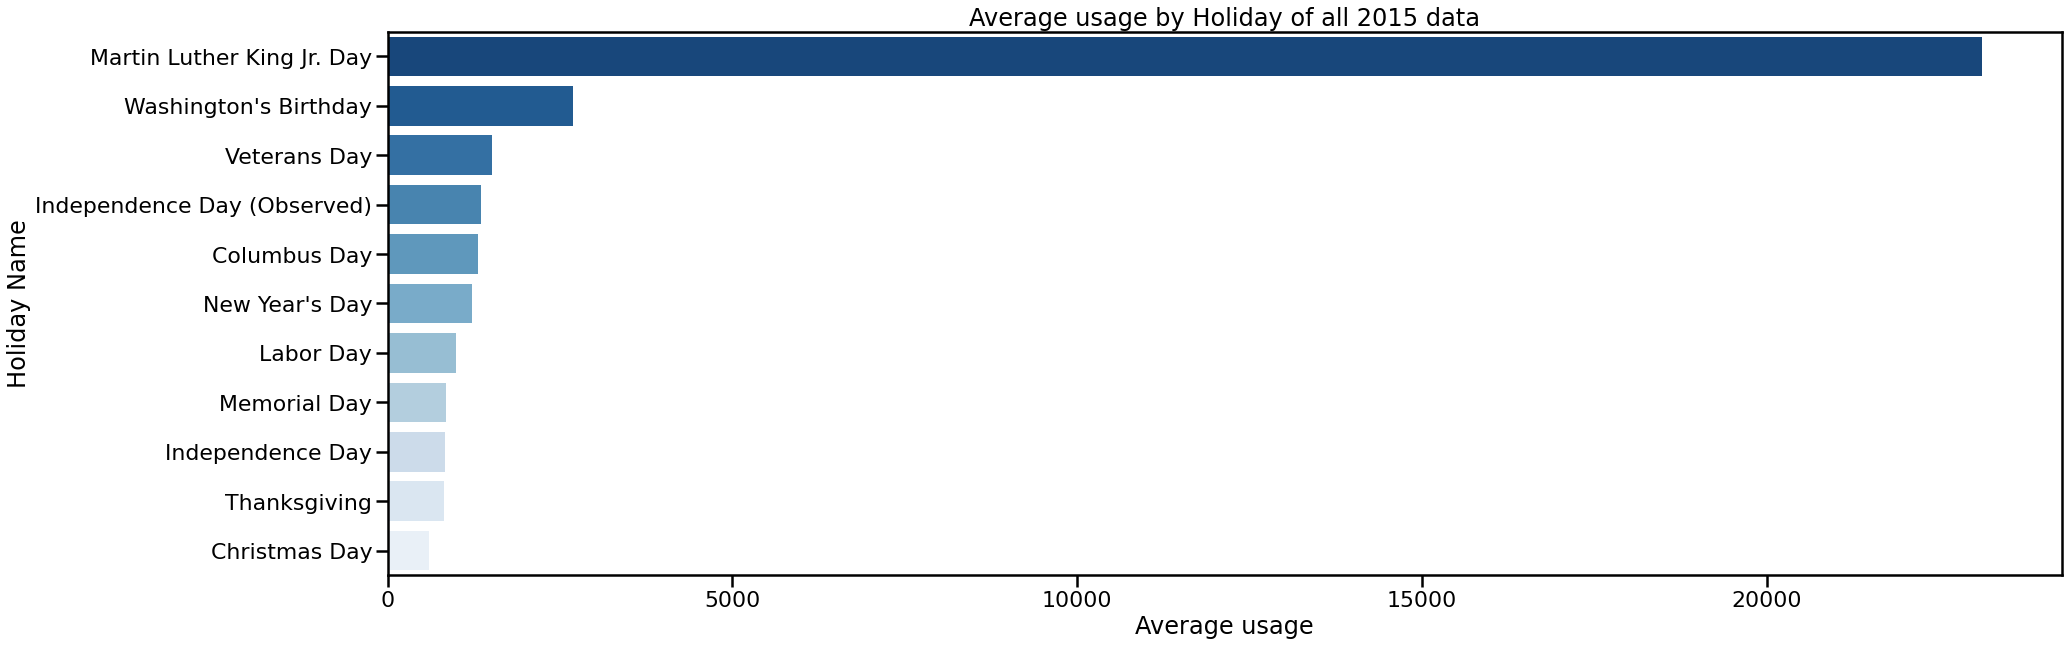

In [19]:
#Gráficos do total de uso dos metrôs por dia e feriado.
fig, axs = plt.subplots(figsize=(35, 10),ncols=2)

sns.set_context('poster')
sns.set_color_codes("pastel")

ax1 = sns.barplot(x="date_day", y="total_use", estimator= np.mean,  data=df_unificado, color = 'r', label='Total', ci = None, order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=axs[0])
ax2 = sns.barplot(x="date_day", y="entries", estimator= np.mean, data=df_unificado, color = 'b',  label='Entries', ci = None, order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=axs[0])

ax2.set(xlabel="Weekday", ylabel = "Average usage", title='Average usage by day of the week of all 2015 data')
ax2.legend()

ax3 = sns.barplot(x="date_day", y="total_use", hue ='holiday_dummy', palette='pastel', estimator= np.mean, data=df_unificado, ci = None, order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=axs[1])
ax3.set(xlabel="Holiday", ylabel = "Average usage", title='Average usage by Holiday and day of the week of all 2015 data')

fig, axs = plt.subplots(figsize=(30, 10))

ax4 = sns.barplot(y="holiday_name", x="total_use", estimator= np.mean, data=holidays, ci = None,  palette='Blues_r')
ax4.set(xlabel="Average usage", ylabel = "Holiday Name", title='Average usage by Holiday of all 2015 data')


Quando olhamos para os dias da semana em todos os metrôs, notamos uma queda de uso no decorrer da semana, sendo sábado o dia menos usado.

Uma análise que poderia ser feita, é se há estações específicas que sobem essa média de uso aos finais de semana.

Podemos notar também que as entradas em média são maiores que as saídas, dá a entender que há viagens com saídas para outras estações não presentes no df (talvez outra cidade).
```
Entradas
df_unificado['entries'].sum() aproximadamente 75.94e9

Saídas
df_unificado['exits'].sum() aproximadamente 61.48e9

Diferença
(df_unificado['entries'].sum()/df_unificado['exits'].sum())-1 aproximadamente 23% maior
```
A média de uso é maior na segunda feira, mas isso pode ser influenciado pela quantidade de feriados nas segundas feiras.

Olhando para os feriados em sí, notamos a grande média de uso no dia do Martin Luther King Jr (pesquisei e nesse dia há muitos tours pelo Harlem e Central Park, bem como shows e atividades de museu), seguido do Washington's Birthday.


In [20]:
# Criando datafame com top 10 estações e métricas de representatividade do total e também do top 10.
df_top10_usage = df_unificado.groupby(['station']).total_use.sum().reset_index().sort_values('total_use', ascending=False).head(10)
df_top10_usage['Accum_perc_total'] = df_top10_usage['total_use']/df_unificado['total_use'].sum()*100
df_top10_usage['Accum_perc_top10'] = df_top10_usage['total_use']/df_top10_usage['total_use'].sum()*100
df_top10_usage

,station,total_use,Accum_perc_total,Accum_perc_top10
122,57 ST-7 AVE,1.350093e+10,9.823667,20.596777
96,42 ST-PA BUS TE,9.477459e+09,6.896074,14.458642
12,125 ST,7.891798e+09,5.742300,12.039585
64,23 ST,5.337670e+09,3.883843,8.143054
98,42 ST-TIMES SQ,5.205881e+09,3.787949,7.941998
125,59 ST-COLUMBUS,5.125204e+09,3.729246,7.818919
470,OXFORD-104 ST,5.016735e+09,3.650321,7.653441
144,72 ST,5.013379e+09,3.647879,7.648321
1,1 AVE,4.967343e+09,3.614382,7.578089
338,FULTON ST,4.012353e+09,2.919504,6.121173


Como podemos notar na tabela acima, a estação '57 ST-7 AVE' é a mais usada quando olhamos entradas e saídas de todas as estações. 

Sozinha ela representa 9,8% do uso "de todas as estações" e 20,6% do uso "entre as top 10 estações mais usadas". Tendo 6 p.p acima da segunda mais usada '42 ST-PA BUS TE'.

[Text(0, 0.5, 'Station'),
 Text(0.5, 0, 'Total Entries & Exits'),
 Text(0.5, 1.0, 'Top 10 Station by usage')]

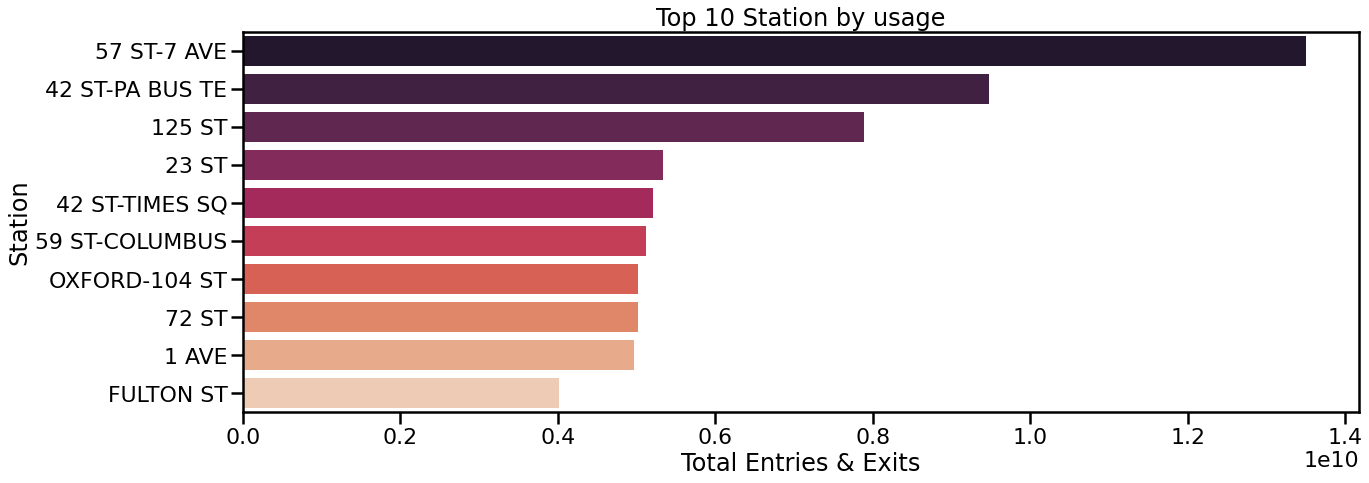

In [21]:
fig, axs = plt.subplots(figsize=(20, 7))

ax = sns.barplot(y="station", x="total_use", estimator= np.mean, data=df_top10_usage, ci = None,  palette='rocket')
ax.set(xlabel="Total Entries & Exits", ylabel = "Station", title='Top 10 Station by usage')

## Selecionando base padrão para a modelagem

Para a modelagem, tentarei prever a quantiadade de usos (entrada + saída) da estação "57 ST-7 AVE" por dia. Escolhi essa estação por ser a de maior fluxo.

Por entender que se trata de um problema que pode ser resolvido com série temporal, utilizarei a biblioteca Prophet em duas frentes (poderiam ser mais).

1. Utilizando apenas quantidades de uso por dia.
2. Acrescentando regressores.

In [22]:
#Separando base de dados para modelagem.
df_modelagem = df_unificado[df_unificado['station']=='57 ST-7 AVE'].copy()
df_modelagem['month'] = df_modelagem['date'].dt.month 
print(df_modelagem.shape)
df_modelagem.head(5)

(5036, 13)


,station,ca,unit,scp,date,entries,exits,total_use,holiday_name,holiday_dummy,date_day,month,half_month
484507,57 ST-7 AVE,A010,R080,00-00-00,2015-01-01,1222.0,520.0,1742.0,New Year's Day,1,Thursday,1,0
484508,57 ST-7 AVE,A010,R080,00-00-00,2015-01-02,990.0,715.0,1705.0,NaN,0,Friday,1,0
484509,57 ST-7 AVE,A010,R080,00-00-00,2015-01-03,1029.0,780.0,1809.0,NaN,0,Saturday,1,0
484510,57 ST-7 AVE,A010,R080,00-00-00,2015-01-04,741.0,592.0,1333.0,NaN,0,Sunday,1,0
484511,57 ST-7 AVE,A010,R080,00-00-00,2015-01-05,857.0,1037.0,1894.0,NaN,0,Monday,1,0


In [23]:
#Verificando quantidade de ocorrências no mês e valores. Como vimos na distribuição do mês (lá no início), vamos olhar se ele impacta o nosso dataframe.
df_modelagem.groupby(['month']).agg({'entries':'sum', 'exits':'sum', 'total_use':'sum','month':'count'}).rename(columns={'month':'count'}).reset_index()

,month,entries,exits,total_use,count
0,1,4.058390e+05,3.420400e+05,7.478790e+05,434
1,2,7.203118e+09,6.288517e+09,1.349164e+10,389
2,3,4.767050e+05,3.954670e+05,8.721720e+05,434
3,4,4.681610e+05,3.922280e+05,8.603890e+05,420
4,5,4.841090e+05,3.938090e+05,8.779180e+05,434
5,6,4.731760e+05,3.979740e+05,8.711500e+05,419
6,7,4.476880e+05,3.951270e+05,8.428150e+05,434
7,8,4.440030e+05,3.778660e+05,8.218690e+05,434
8,9,4.526700e+05,3.904700e+05,8.431400e+05,420
9,10,5.156980e+05,4.290730e+05,9.447710e+05,434


Como podemos observar, essa estação foi impactada em fevereiro, onde seus valores são muito superiores aos outros meses.

Pra tentar entender, vou abrir esse mês e verificar se foi algum dia específico.

In [24]:
valid = df_modelagem[df_modelagem['month']==2].groupby(['date','station']).agg({'entries':'sum', 'exits':'sum', 'total_use':'sum'}).reset_index().sort_values('date', ascending=True)
valid

,date,station,entries,exits,total_use
0,2015-02-01,57 ST-7 AVE,1.024400e+04,6.876000e+03,1.712000e+04
1,2015-02-02,57 ST-7 AVE,1.111700e+04,1.124000e+04,2.235700e+04
2,2015-02-03,57 ST-7 AVE,1.388800e+04,1.192900e+04,2.581700e+04
3,2015-02-04,57 ST-7 AVE,1.701600e+04,1.361900e+04,3.063500e+04
4,2015-02-05,57 ST-7 AVE,1.714800e+04,1.376000e+04,3.090800e+04
5,2015-02-06,57 ST-7 AVE,1.735100e+04,1.426500e+04,3.161600e+04
6,2015-02-07,57 ST-7 AVE,1.397500e+04,8.770000e+03,2.274500e+04
7,2015-02-08,57 ST-7 AVE,1.132900e+04,8.007000e+03,1.933600e+04
8,2015-02-09,57 ST-7 AVE,1.173300e+04,1.293700e+04,2.467000e+04
9,2015-02-10,57 ST-7 AVE,1.595200e+04,1.428600e+04,3.023800e+04


In [25]:
print("Média do mês: ", round(valid["total_use"].mean(),2))
print("Média do mês sem os 2 dias de pico: ",  round(valid[~valid['date'].isin(['2015-02-24','2015-02-25'])]["total_use"].mean(),2))

Média do mês:  481844122.11
Média do mês sem os 2 dias de pico:  26194.73


Como podemos notar, os dias 24 e 25 foram atípicos e com grandes picos, a média era aproximadamente 26 mil usos diários, e considerando os dois dias atípicos a média sobe para aproximadamente 482 milhões.

Devido a grande diferença, acredito ser algum input incorreto no dia, sensor (CA) ou até mesmo algum horário do dia (seria uma próxima análise). 

Irei remover esses 2 dias dos registros para não termos influência de outlier.


[Text(0, 0.5, 'Average usage'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average usage by month of all 2015 data')]

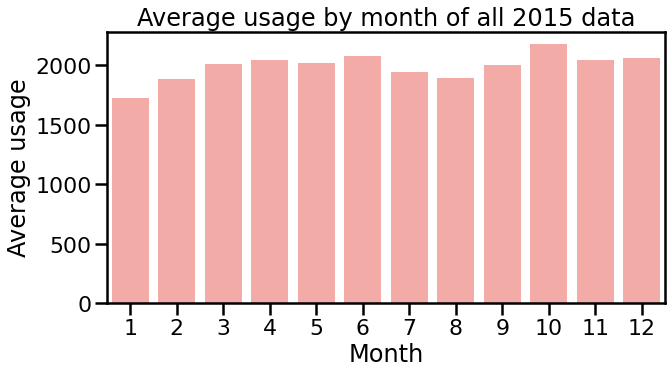

In [26]:
#Removendo os 2 dias mencionados e avaliando a nova distribuição.
df_modelagem = df_modelagem[~df_modelagem['date'].isin(['2015-02-24','2015-02-25'])]

fig, axs = plt.subplots(figsize=(10, 5))
sns.barplot(x="month", y="total_use", data=df_modelagem, color = 'r', label='Total', ci = None)
axs.set(xlabel="Month", ylabel = "Average usage", title='Average usage by month of all 2015 data')

[Text(0, 0.5, 'Holiday Name'),
 Text(0.5, 0, 'Average usage'),
 Text(0.5, 1.0, 'Average usage by Holiday of all 2015 data')]

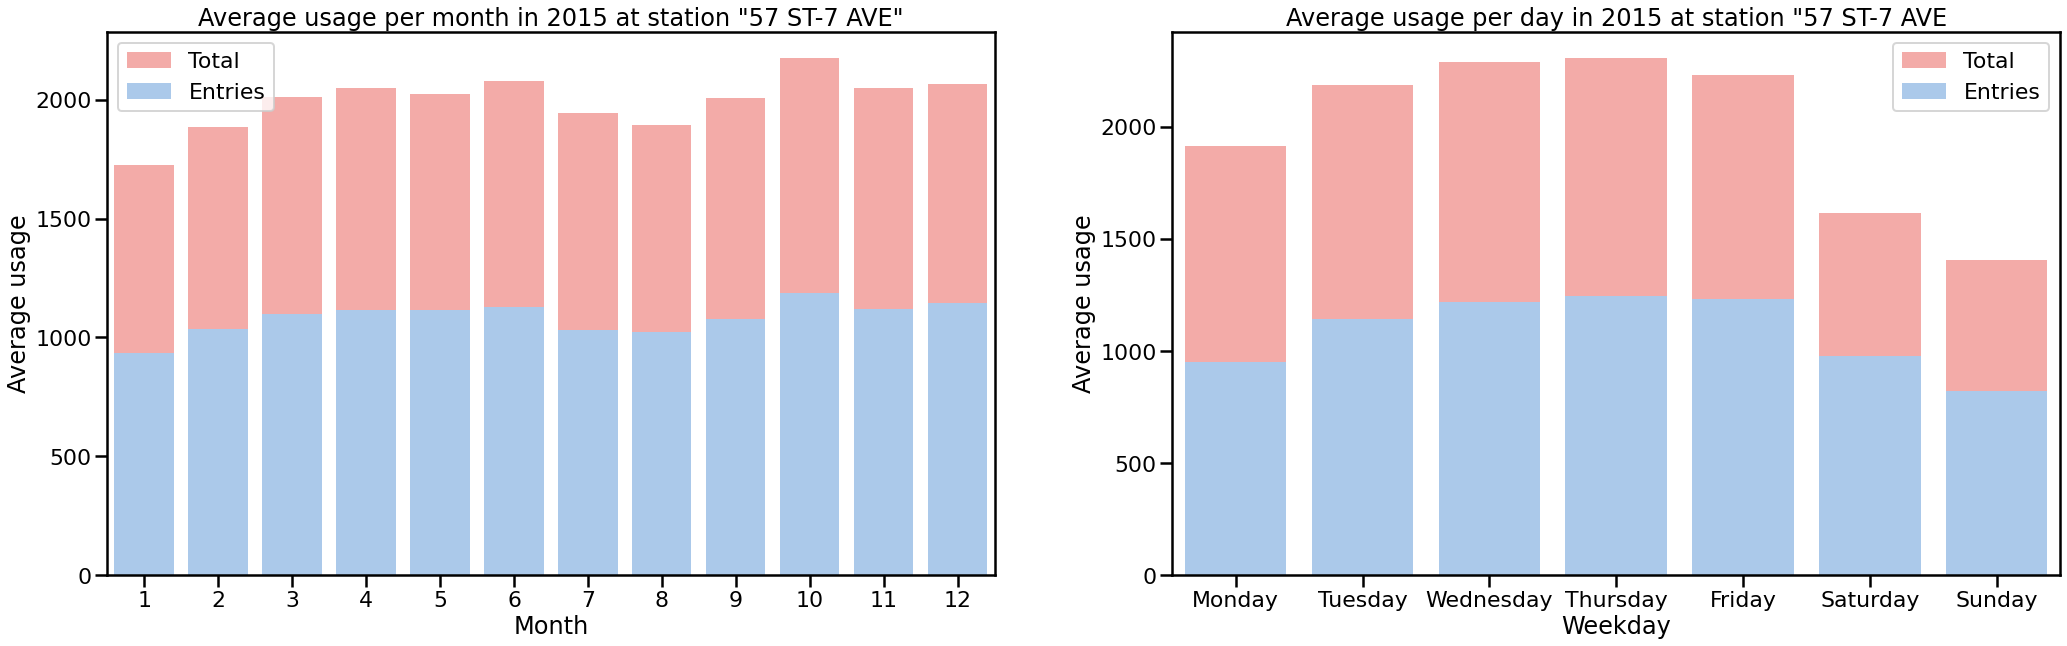

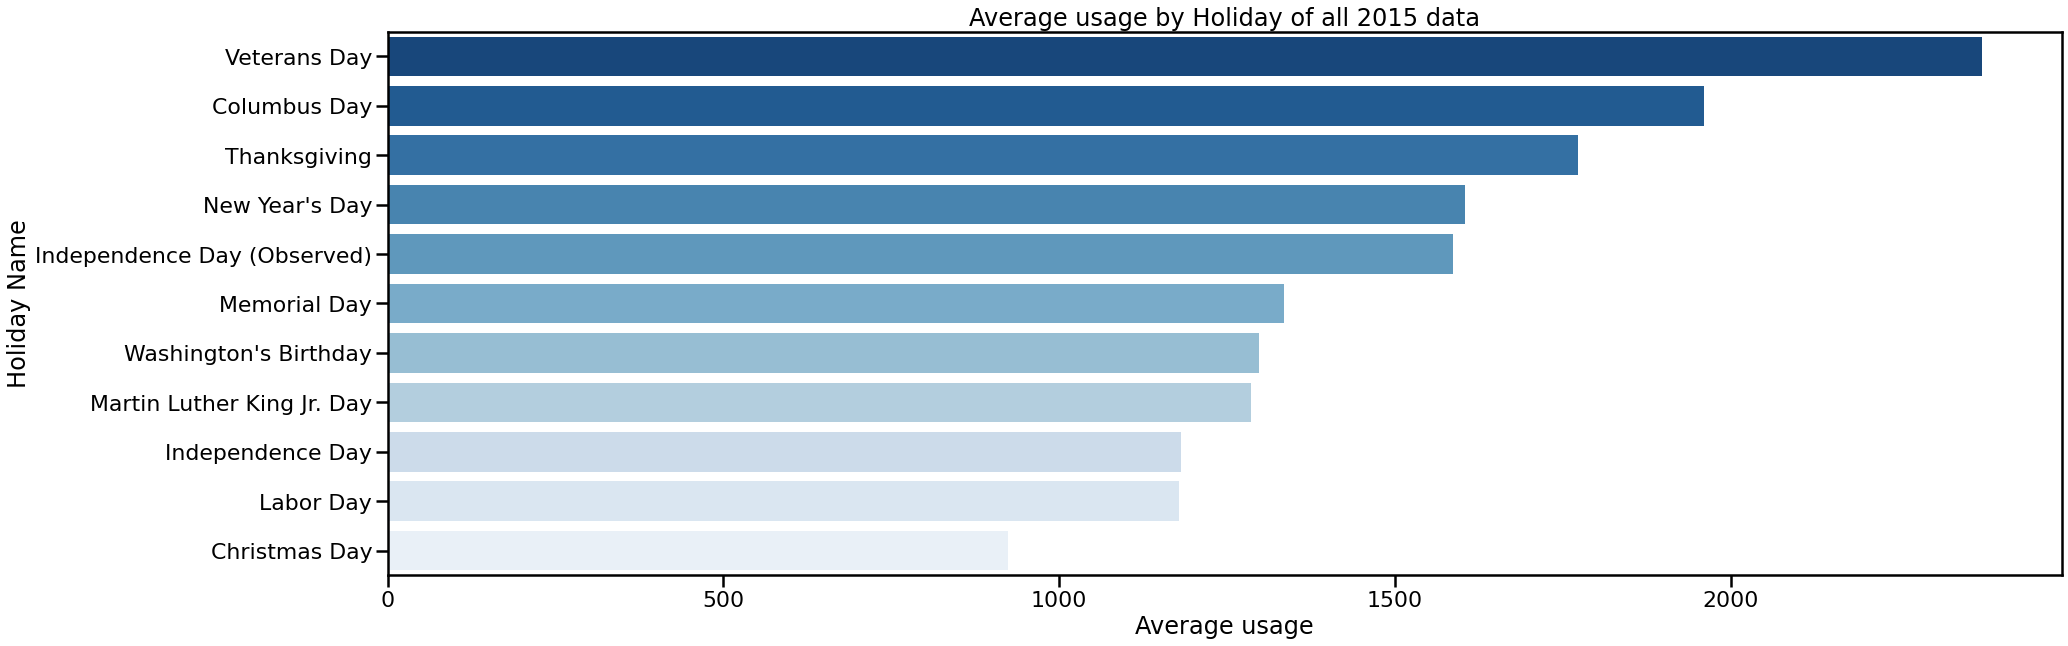

In [27]:
#Gráficos do total de uso dos metrôs na estação por mês, dia e feriado.
df_modelagem['month'] = df_modelagem['date'].dt.month 

fig, axs = plt.subplots(figsize=(35, 10),ncols=2)

sns.set_context('poster')
sns.set_color_codes("pastel")
          
ax1 = sns.barplot(x="month", y="total_use", estimator= np.mean,  data=df_modelagem, color = 'r', label='Total', ci = None, ax=axs[0])
ax2 = sns.barplot(x="month", y="entries", estimator= np.mean, data=df_modelagem, color = 'b',  label='Entries', ci = None, ax=axs[0])

ax2.set(xlabel="Month", ylabel = "Average usage", title='Average usage per month in 2015 at station "57 ST-7 AVE"')
ax2.legend()

ax3 = sns.barplot(x="date_day", y="total_use", estimator= np.mean,  data=df_modelagem, color = 'r', label='Total', ci = None, order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=axs[1])
ax4 = sns.barplot(x="date_day", y="entries", estimator= np.mean, data=df_modelagem, color = 'b',  label='Entries', ci = None, order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=axs[1])

ax4.set(xlabel="Weekday", ylabel = "Average usage", title='Average usage per day in 2015 at station "57 ST-7 AVE')
ax4.legend()

fig, axs = plt.subplots(figsize=(30, 10))

holidays_model = df_modelagem.groupby(['holiday_name', 'holiday_dummy', 'date_day']).total_use.mean().reset_index().sort_values("total_use", ascending=False)
ax4 = sns.barplot(y="holiday_name", x="total_use", estimator= np.mean, data=holidays_model, ci = None,  palette='Blues_r')
ax4.set(xlabel="Average usage", ylabel = "Holiday Name", title='Average usage by Holiday of all 2015 data')


Como podemos notar, o uso dessa estação tem comportamento bem diferente de quando olhamos o 'todo'.

Seu uso é bastante linear no decorrer dos meses. Quando olhamos durante a semana, ela tem menos uso aos finais de semana e máximas nas quartas e quintas feiras.

Fiquei bastante impressionado com a diferença nos feriados. Penso em uma hipóteses sobre o uso do metrô no feriado do Martin Luther King ser relacionado a algumas regiões específica da cidade (seria interessante pra uma análise futura).

# **Modelagem - Série Temporal**

Prevendo 15 dias de uso (entradas + saídas) do da estação "57 ST-7 AVE" com Prophet, aplicando de duas formas, sendo:

1 - Utilizando apenas quantidades de uso por dia.

2 - Acrescentando regressores.

## Primeiro modelo proposto

### Preparando o dataframe

In [28]:
#Preparando dataframe, deixando apenas data e uso total em ordem cronológica.
df_prophet = df_modelagem.groupby(['date']).total_use.sum().reset_index().sort_values('date', ascending=True)
df_prophet.head(5)

,date,total_use
0,2015-01-01,22462.0
1,2015-01-02,20307.0
2,2015-01-03,18779.0
3,2015-01-04,13631.0
4,2015-01-05,23663.0


In [29]:
#O prophet necessita de padronização dos nomes das colunas.
df_prophet = df_prophet.rename(columns={'date': 'ds', 'total_use': 'y'})
df_prophet.head(5)

,ds,y
0,2015-01-01,22462.0
1,2015-01-02,20307.0
2,2015-01-03,18779.0
3,2015-01-04,13631.0
4,2015-01-05,23663.0


### Definindo a base de treino e teste

In [30]:
#Como decidi prever 15 dias, vou tentar prever os primeiros 15 dias de dezembro.
#Aqui já antecipo a possibilidade de haver grande erro, devido as festas de fim de ano e o baixo uso da estação nessa época (apresentado em feriados).
data_corte_inicio = '2015-11-30'
data_corte_fim = '2015-12-16'

# definindo os dados de treino, antes da data de corte.
train = df_prophet.loc[df_prophet['ds'] <= data_corte_inicio]
print(train.tail(5), '\n ---------------')

# definindo os dados de teste posterior a data de corte.
test = df_prophet.loc[(df_prophet['ds'] > data_corte_inicio) & (df_prophet['ds'] <= data_corte_fim)]
print(test.head(5), '\n ---------------')

            ds        y
327 2015-11-26  24819.0
328 2015-11-27  16212.0
329 2015-11-28  19652.0
330 2015-11-29  18183.0
331 2015-11-30  26265.0 
 ---------------
            ds        y
332 2015-12-01  32373.0
333 2015-12-02  33969.0
334 2015-12-03  35160.0
335 2015-12-04  35640.0
336 2015-12-05  26370.0 
 ---------------


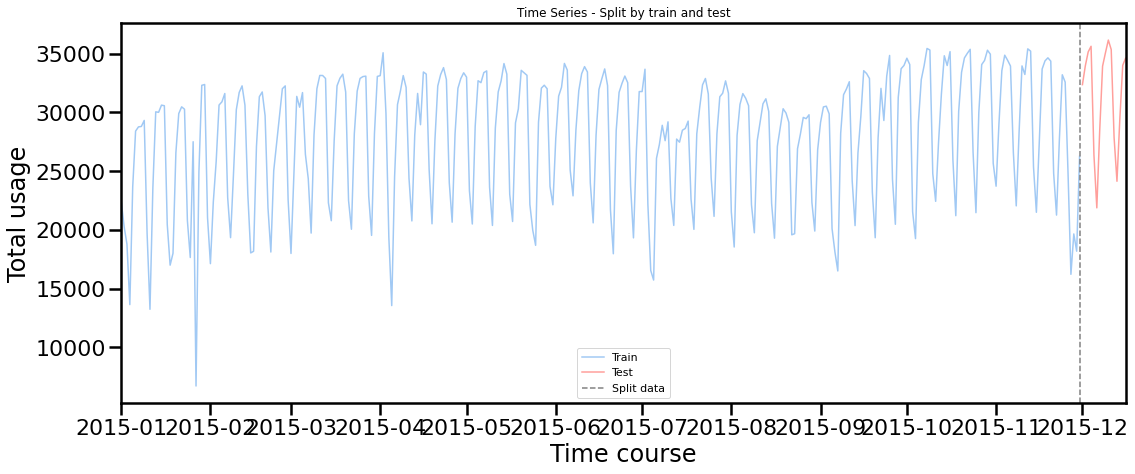

In [31]:
#Plotando série temporal com marcação da separação de bases.
fig, ax = plt.subplots(figsize=(18, 7))

sns.set_context('notebook')
sns.set_color_codes("pastel")

sns.lineplot(x="ds", y="y",data=train, color="b", label = 'Train')
sns.lineplot(x="ds", y="y",data=test, color="r", label = 'Test')
ax.axvline(pd.to_datetime(data_corte_inicio), label='Split data', color='gray', linestyle='--' )

ax.set(xlabel="Time course", ylabel = "Total usage", title='Time Series - Split by train and test')
ax.set_xlim(train['ds'].min(), test['ds'].max())
plt.legend(loc='lower center');

### Treinamento do modelo
Apenas data e volume de uso

In [32]:
# Instanciando e treinando modelo.
m = Prophet().fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Eu gosto do Prophet pela facilidade em utilizar e aplicar parâmetros. Aqui ele já informa sobre sazonalidades que não estão ativas.

A sazonalidade anual não faz sentido pois estamos apenas com 1 ano em estudo, 2015. Mas poderíamos incluir dados de 2014 e habilitarmos.

A sazonalidade diária é a sazonalidade de horas do dia, como agrupamos por dia, também não faz sentido nesse momento. Mas poderíamos quebrar em grupos de horários e também habilitarmos.

### Aplicando modelo criado na base de treino, pra avaliarmos seu comportamento e componentes da série temporal

In [33]:
# Criando dataframe com as datas futuras (O prophet possui função própria para isso, descrita abaixo), mas como temos a nossa base teste, não usaremos.
#future = m.make_future_dataframe(periods=15) #Exemplo utilizando 15 dias de previsão.

# Aplicando previsão do modelo.
forecast_train = m.predict(train)

# olhando os resultados das previsões com os dados de treino ( data, previsão, e intervalos de incerteza).
forecast_train[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
327,2015-11-26,33995.164411,30904.076966,37387.652617
328,2015-11-27,33054.729645,29734.013036,36325.259892
329,2015-11-28,24477.480489,21279.263190,27701.392100
330,2015-11-29,21202.477770,17961.627055,24401.229339
331,2015-11-30,28316.227741,25157.091557,31853.270531


<Figure size 1296x504 with 0 Axes>

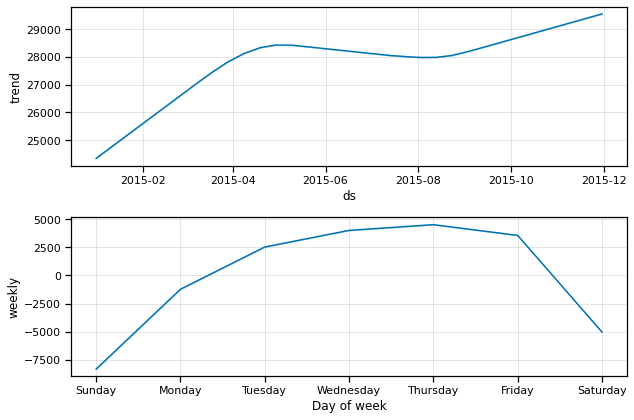

In [34]:
#Verificando as componentes do modelo.
sns.set_context('notebook')

fig, axs = plt.subplots(nrows=0,figsize=(18, 7))

fig = m.plot_components(forecast_train)

Notamos que foi aplicado além da tendência, a sazonalidade semanal.

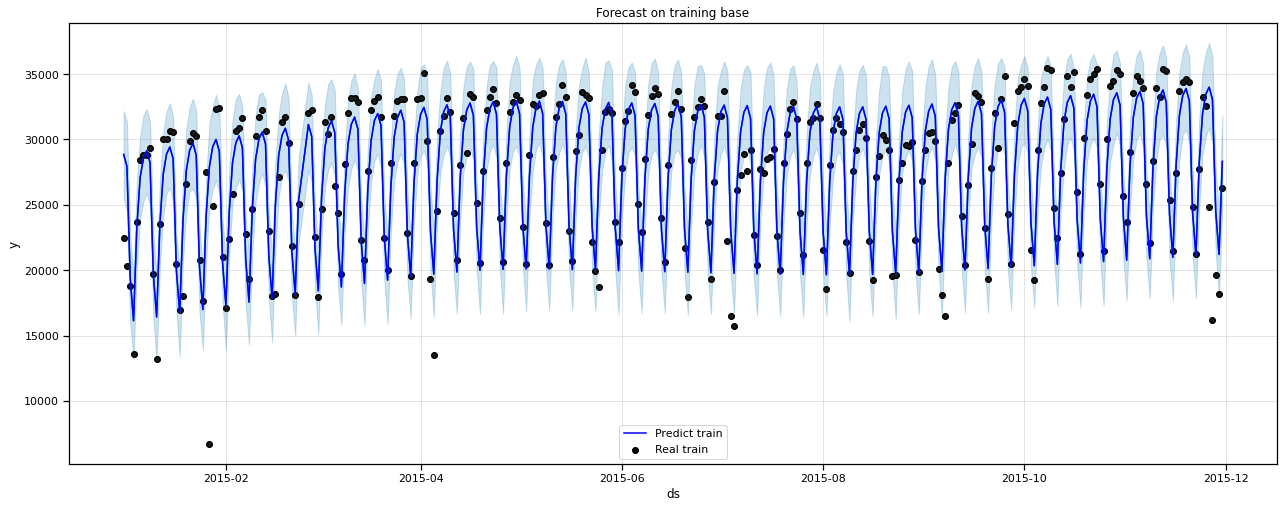

In [35]:
#Plotando modelo e dados utilizados no treinamento. 
fig, ax = plt.subplots(nrows=1,figsize=(18, 7))

sns.set_context('notebook')

fig = m.plot(forecast_train, ax=ax)
sns.lineplot(data=forecast_train, x="ds", y="yhat", color = 'blue', label='Predict train')
ax.scatter(train.ds, train['y'], color='black', label='Real train')

ax.set(title='Forecast on training base')
plt.legend(loc='lower center');

Podemos notar que o modelo entende a série, e seus intervalos de incerteza podem ser trabalhados para maximizar a performance, visto que abrangem grande maioria dos pontos.

### Aplicando modelo treinado na base de teste e avaliando sua perfomance graficamente e com métricas de erro.

In [36]:
#Aplicando modelo na base separada para test.
forecast_test = m.predict(test)

# olhando os resultados das previsões com os dados de teste (data, previsão, e intervalos de incerteza).
forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2015-12-01,32085.235614,28858.005719,35212.754634
1,2015-12-02,33578.600953,30357.228659,36808.787513
2,2015-12-03,34102.912305,30589.840536,37292.059644
3,2015-12-04,33162.477540,29712.292971,36171.081778
4,2015-12-05,24585.228383,21175.718384,27798.491818
5,2015-12-06,21310.225664,18025.718944,24474.701497
6,2015-12-07,28423.975635,24907.316723,31628.479585
7,2015-12-08,32192.983508,28839.785546,35555.076544
8,2015-12-09,33686.348847,30440.828512,36893.952265
9,2015-12-10,34210.660199,30806.747722,37269.285771


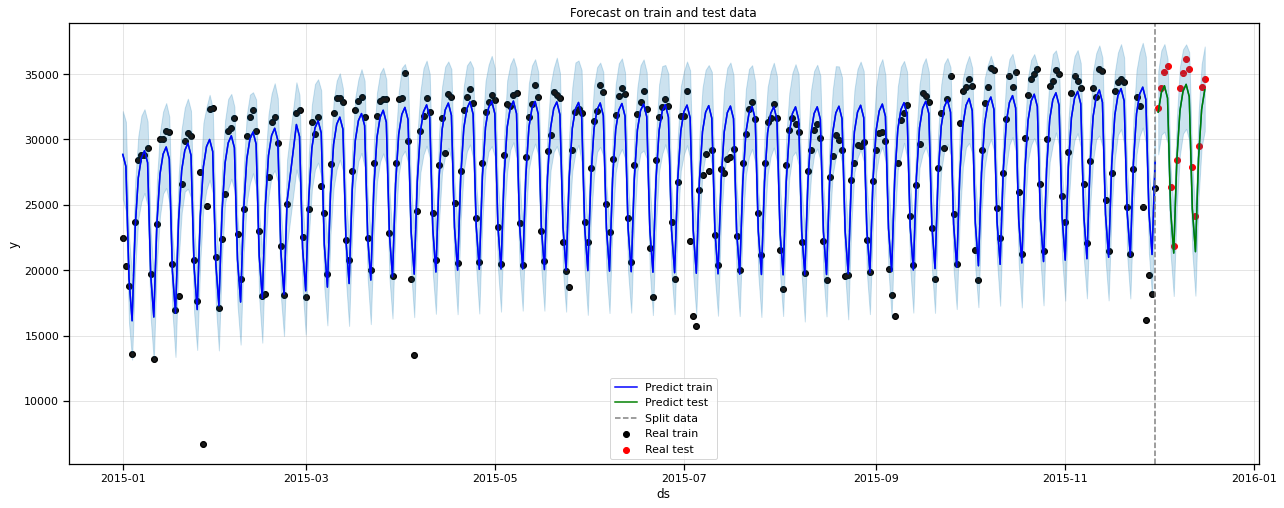

In [37]:
#Plotando modelo na base de treino e teste. 
fig, ax = plt.subplots(nrows=1,figsize=(18, 7))
sns.set_context('notebook')

ax.scatter(train.ds, train['y'], color='black', label='Real train')
ax.scatter(test.ds, test['y'], color='red', label='Real test')

fig = m.plot(forecast_train, ax=ax)
fig = m.plot(forecast_test, ax=ax)

sns.lineplot(data=forecast_train, x="ds", y="yhat", color = 'blue', label='Predict train')
sns.lineplot(data=forecast_test, x="ds", y="yhat", color = 'green',  label='Predict test')

ax.axvline(pd.to_datetime(data_corte_inicio), color='gray', linestyle='--', label='Split data')
ax.set(title='Forecast on train and test data')
plt.legend(loc='lower center');

Graficamente o modelo aparenta ter boa perfomance, poderia ser realizado melhorias, como por exemplo tratativas para o uso das medidas de incerteza.

In [38]:
# Dando uma olhada na predição e valor real.
forecast_valid = forecast_test[['ds', 'yhat']].merge(test, how='left', on='ds')

In [39]:
print('Valor real total', round(forecast_valid['y'].sum(),2), '\n ---------------')
print('Valor real médio', round(forecast_valid['y'].mean(),2), '\n ---------------')
print('Valor predito total', round(forecast_valid['yhat'].sum(),2), '\n ---------------')
print('Valor predito médio', round(forecast_valid['yhat'].mean(),2), '\n ---------------')

Valor real total 504524.0 
 ---------------
Valor real médio 31532.75 
 ---------------
Valor predito total 481346.38 
 ---------------
Valor predito médio 30084.15 
 ---------------


In [40]:
# Criando função para as métricas de erro.
def calc_erros(array_real, array_previsto):
  array_real, array_previsto = np.array(array_real), np.array(array_previsto)
  erro = array_real - array_previsto #ERROR
  erro_medio = round(np.mean(erro),2) # ME
  erro_medio_absoluto = round(np.mean(abs(erro)),2) #MAE
  erro_quadrado_medio = round(np.mean(np.square(erro)),2) #MSE
  raiz_erro_quadrado_medio = round(np.sqrt(erro_quadrado_medio),2) #RMSE
  erro_percentual_medio_absoluto = round(np.mean(np.abs((erro) / array_real)) * 100,2) #MAPE
  erros = {'ME': erro_medio, 'MAE': erro_medio_absoluto, 'MSE': erro_quadrado_medio, 'RMSE': raiz_erro_quadrado_medio, 'MAPE':erro_percentual_medio_absoluto}
  return pd.DataFrame([erros])

In [41]:
# Aplicando métricas para avaliar o resultado na base de teste.
calc_erros(test['y'],forecast_test['yhat'])

,ME,MAE,MSE,RMSE,MAPE
0,1448.6,1448.6,2891881.46,1700.55,4.7


Como podemos ver, nosso modelo tem média de erro positiva, significa que ele 'deixando' de contabilizar 1.448 (entradas+saidas) por dia nesse período.
Esse valor representa 4,7% de erro, ao meu ver está bastante aderente, mesmo utilizando pouco recursos do Prophet.

## Segundo modelo proposto

Pra esse segundo modelo, pretendo acrescentar regressores pra avaliar se haverá ganho nas previsões.

Faremos todas as etapas anteriores e acrescentaremos as novas variáveis.

### Preparando o dataframe

In [42]:
# Para esse teste comparativo, irei acrescentar as informações de feriado, dia da semana, mês e se é ou não metade do mês.
# Agrupei somando o uso total, e substitui as variáveis de data e resposta, conforme documentação.
df_prophet_2 = df_modelagem.groupby(['date','holiday_dummy','date_day','month','half_month']).total_use.sum().reset_index().sort_values('date', ascending=True)
df_prophet_2.rename(columns={'date': 'ds', 'total_use': 'y'}, inplace = True)
df_prophet_2.head(5)

,ds,holiday_dummy,date_day,month,half_month,y
0,2015-01-01,1,Thursday,1,0,22462.0
1,2015-01-02,0,Friday,1,0,20307.0
2,2015-01-03,0,Saturday,1,0,18779.0
3,2015-01-04,0,Sunday,1,0,13631.0
4,2015-01-05,0,Monday,1,0,23663.0


In [43]:
# Criando variáveis dummy para inclusão como regressor.
df_prophet_2 = pd.get_dummies(df_prophet_2, columns=['month','date_day'])
df_prophet_2.head(5)

,ds,holiday_dummy,half_month,y,month_1,month_2,month_3,month_4,month_5,month_6,...,month_10,month_11,month_12,date_day_Friday,date_day_Monday,date_day_Saturday,date_day_Sunday,date_day_Thursday,date_day_Tuesday,date_day_Wednesday
0,2015-01-01,1,0,22462.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2015-01-02,0,0,20307.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2015-01-03,0,0,18779.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2015-01-04,0,0,13631.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2015-01-05,0,0,23663.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Denifindo base de treino e teste

In [44]:
#Como decidi prever 15 dias, vou tentar prever os primeiros 15 dias de dezembro.
#Aqui já antecipo a possibilidade de haver grande erro, devido as festas de fim de ano e o baixo uso da estação nessa época (apresentado em feriados).
data_corte_inicio = '2015-11-30'
data_corte_fim = '2015-12-16'

# definindo os dados de treino, antes da data de corte.
train_2 = df_prophet_2.loc[df_prophet_2['ds'] <= data_corte_inicio]
print(train_2[['ds','y']].tail(5), '\n ---------------')

# definindo os dados de teste posterior a data de corte.
test_2 = df_prophet_2.loc[(df_prophet_2['ds'] > data_corte_inicio) & (df_prophet_2['ds'] <= data_corte_fim)]
print(test_2[['ds','y']].head(5), '\n ---------------')

            ds        y
327 2015-11-26  24819.0
328 2015-11-27  16212.0
329 2015-11-28  19652.0
330 2015-11-29  18183.0
331 2015-11-30  26265.0 
 ---------------
            ds        y
332 2015-12-01  32373.0
333 2015-12-02  33969.0
334 2015-12-03  35160.0
335 2015-12-04  35640.0
336 2015-12-05  26370.0 
 ---------------


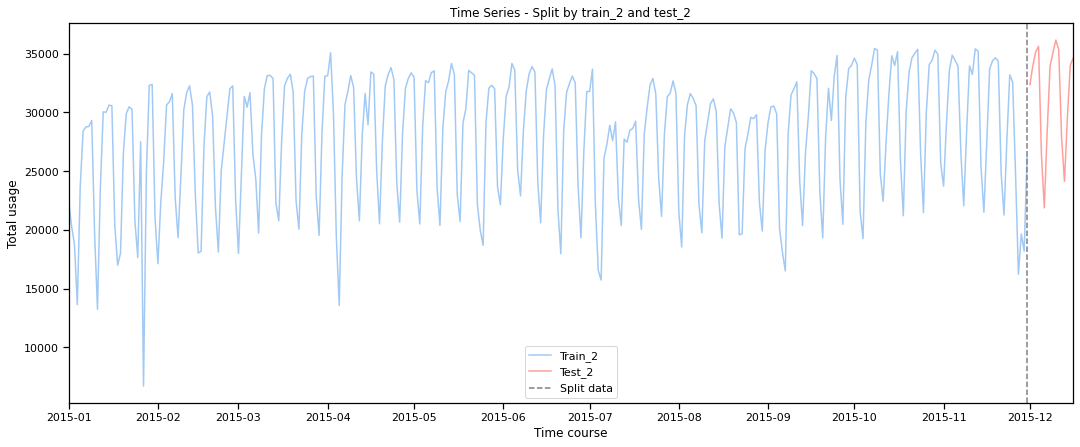

In [45]:
#Plotando série temporal com marcação da separação de bases.
fig, ax = plt.subplots(figsize=(18, 7))

sns.set_context('notebook')
sns.set_color_codes("pastel")

sns.lineplot(x="ds", y="y",data=train_2, color="b", label = 'Train_2')
sns.lineplot(x="ds", y="y",data=test_2, color="r", label = 'Test_2')
ax.axvline(pd.to_datetime(data_corte_inicio), label='Split data', color='gray', linestyle='--' )

ax.set(xlabel="Time course", ylabel = "Total usage", title='Time Series - Split by train_2 and test_2')
ax.set_xlim(train_2['ds'].min(), test_2['ds'].max())
plt.legend(loc='lower center');

### Treinamento do modelo#

Para acrescentar regressores no prophet, primeiro devemos gerar o modelo e posteriormente setar todas as variáveis que iremos utilizar (não aceita lista).

In [46]:
# Todas as colunas existentes
test_2.columns

Index(['ds', 'holiday_dummy', 'half_month', 'y', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'date_day_Friday',
       'date_day_Monday', 'date_day_Saturday', 'date_day_Sunday',
       'date_day_Thursday', 'date_day_Tuesday', 'date_day_Wednesday'],
      dtype='object')

In [47]:
# Instanciando o modelo.
m = Prophet()

# Acrescentando regressores
m.add_regressor('holiday_dummy')
m.add_regressor('half_month')
m.add_regressor('month_1')
m.add_regressor('month_2')
m.add_regressor('month_3')
m.add_regressor('month_4')
m.add_regressor('month_5')
m.add_regressor( 'month_6')
m.add_regressor( 'month_7')
m.add_regressor( 'month_8')
m.add_regressor('month_9')
m.add_regressor( 'month_10')
m.add_regressor( 'month_11')
m.add_regressor('month_12')
m.add_regressor('date_day_Friday')
m.add_regressor('date_day_Monday')
m.add_regressor('date_day_Saturday')
m.add_regressor('date_day_Sunday')
m.add_regressor('date_day_Thursday')
m.add_regressor('date_day_Tuesday')
m.add_regressor('date_day_Wednesday')

# Treinando o modelo
m.fit(train_2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Como podemos notar, mesmo com o acréscimo do regressor, o Prophet continua sinalizando sobre a possibilidade de utiizar as sazonalidades.

### Aplicando modelo criado na base de treino_2, pra avaliarmos seu comportamento e componentes da série temporal

In [48]:
# Criando dataframe com as datas futuras (O prophet possui função própria para isso, descrita abaixo), mas como temos a nossa base teste, não usaremos.
#future = m.make_future_dataframe(periods=15) #Exemplo utilizando 15 dias de previsão.

# Aplicando previsão do modelo.
forecast_train_2 = m.predict(train_2)

# olhando os resultados das previsões com os dados de treino_2 ( data, previsão, e intervalos de incerteza).
forecast_train_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
327,2015-11-26,27480.373276,24813.158278,30243.779524
328,2015-11-27,33102.606629,30405.431258,35924.868540
329,2015-11-28,24538.436803,21831.451840,27451.040325
330,2015-11-29,21091.139056,18559.402762,23906.954469
331,2015-11-30,28908.925433,26135.512219,31660.133565


<Figure size 1296x504 with 0 Axes>

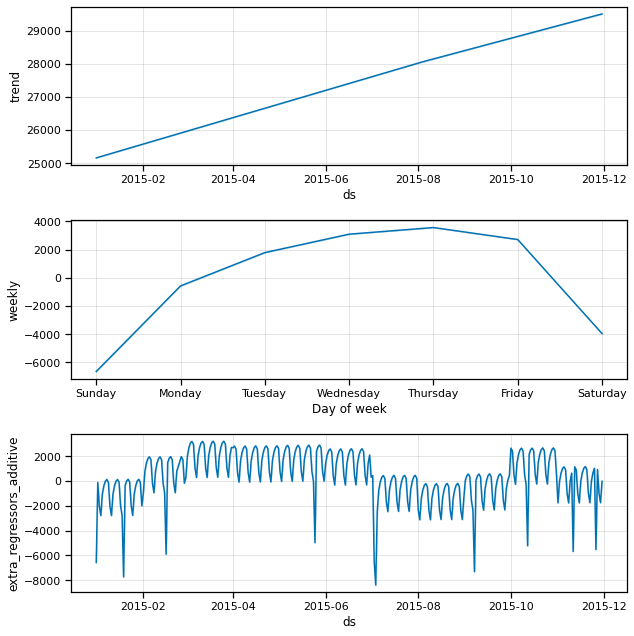

In [49]:
#Verificando as componentes do modelo.
sns.set_context('notebook')

fig, axs = plt.subplots(nrows=0,figsize=(18, 7))

fig = m.plot_components(forecast_train_2)

Notamos que o acréscimo das componentes regressoras como aditivo e também a diferença na tendencia, sendo essa agora muito similar  a uma reta positiva.

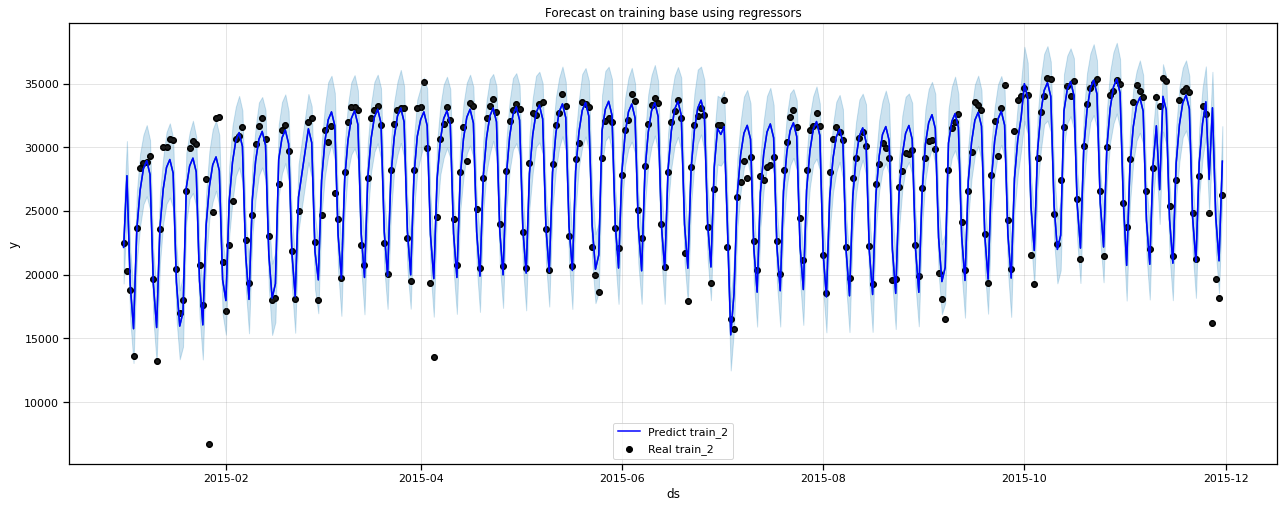

In [50]:
#Plotando modelo e dados utilizados no treinamento. 
fig, ax = plt.subplots(nrows=1,figsize=(18, 7))

sns.set_context('notebook')

fig = m.plot(forecast_train_2, ax=ax)
sns.lineplot(data=forecast_train_2, x="ds", y="yhat", color = 'blue', label='Predict train_2')
ax.scatter(train_2.ds, train_2['y'], color='black', label='Real train_2')

ax.set(title='Forecast on training base using regressors')
plt.legend(loc='lower center');

Podemos notar que o modelo continua entendendo a série, a diferença é que com a inclusão dos regressores, agora ele consegue se ajustar um pouco a mais nos dados, como picos e vales exibidos.

### Aplicando modelo treinado na base de teste_2 e avaliando sua perfomance graficamente e com métricas de erro.

In [51]:
#Aplicando modelo na base separada para test_2.
forecast_test_2 = m.predict(test_2)

#Olhando os resultados das previsões com os dados de teste_2 (data, previsão, e intervalos de incerteza).
forecast_test_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2015-12-01,32201.729149,29416.883069,35024.439723
1,2015-12-02,33894.275787,31044.076397,36493.733947
2,2015-12-03,34512.170391,31636.832322,37371.984112
3,2015-12-04,33430.015323,30525.890033,36144.299044
4,2015-12-05,24865.845496,22164.601074,27406.729556
5,2015-12-06,21418.547750,18575.139577,24000.921402
6,2015-12-07,29236.334127,26361.993107,31877.469033
7,2015-12-08,32287.338292,29446.530987,34895.163852
8,2015-12-09,33979.884930,31203.442992,36658.647482
9,2015-12-10,34597.779535,31762.980526,37171.851785


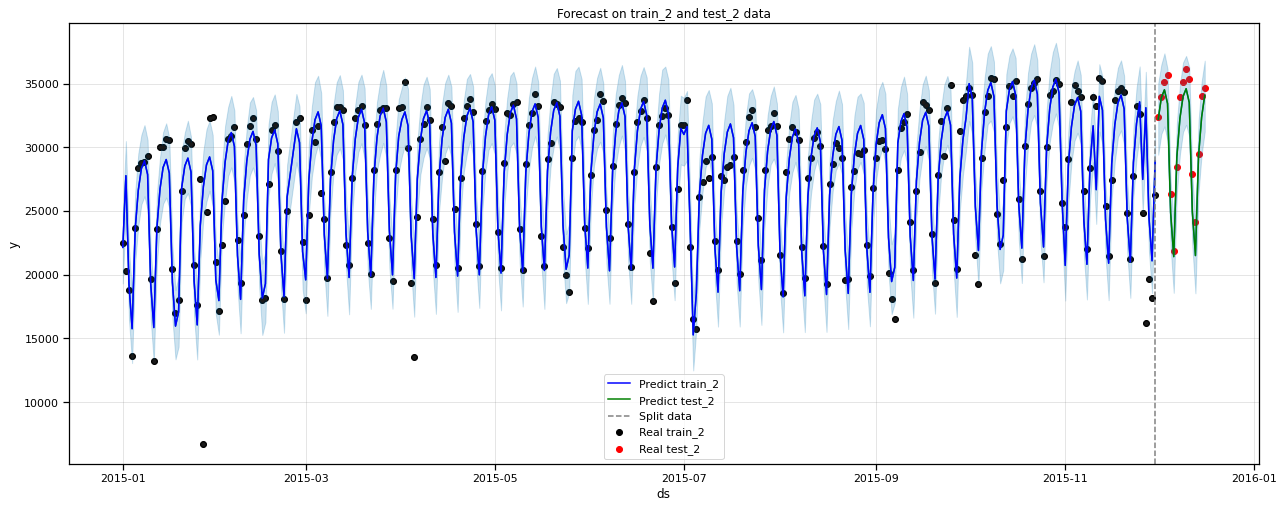

In [52]:
#Plotando modelo na base de treino_2 e teste_2. 
fig, ax = plt.subplots(nrows=1,figsize=(18, 7))
sns.set_context('notebook')

ax.scatter(train_2.ds, train_2['y'], color='black', label='Real train_2')
ax.scatter(test_2.ds, test_2['y'], color='red', label='Real test_2')

fig = m.plot(forecast_train_2, ax=ax)
fig = m.plot(forecast_test_2, ax=ax)

sns.lineplot(data=forecast_train_2, x="ds", y="yhat", color = 'blue', label='Predict train_2')
sns.lineplot(data=forecast_test_2, x="ds", y="yhat", color = 'green',  label='Predict test_2')

ax.axvline(pd.to_datetime(data_corte_inicio), color='gray', linestyle='--', label='Split data')
ax.set(title='Forecast on train_2 and test_2 data')
plt.legend(loc='lower center');

Graficamente o modelo aparenta continuar com boa perfomance.

Vamos avaliar se houve melhoria nas métricas de erro.

In [53]:
# Dando uma olhada na predição e valor real.
forecast_valid_2 = forecast_test_2[['ds', 'yhat']].merge(test, how='left', on='ds')

In [54]:
print('Valor real total', round(forecast_valid_2['y'].sum(),2), '\n ---------------')
print('Valor real médio', round(forecast_valid_2['y'].mean(),2), '\n ---------------')
print('Valor predito total', round(forecast_valid_2['yhat'].sum(),2), '\n ---------------')
print('Valor predito médio', round(forecast_valid_2['yhat'].mean(),2), '\n ---------------')

Valor real total 504524.0 
 ---------------
Valor real médio 31532.75 
 ---------------
Valor predito total 486172.41 
 ---------------
Valor predito médio 30385.78 
 ---------------


In [55]:
# Aplicando métricas para avaliar o resultado na base de teste.
calc_erros(test_2['y'],forecast_test_2['yhat'])

,ME,MAE,MSE,RMSE,MAPE
0,1146.97,1245.27,2298551.17,1516.1,4.08


Como podemos ver, o acréscimo de regressores ao modelos trouxe benefícios, ele continua com média de erro positiva, mas passou de 'deixar' de contabilizar 1.448 para 1.146 (entradas+saidas) por dia nesse período. Esse valor representa 4,08% de erro. Uma redução de 13%.

# Conclusão

Ao longo desse trabalho, pude conhecer sobre o uso de metrô na cidade de Nova York, por curiosidade também pesquisei sobre os feriados pra entender suas relevâncias e impactos no uso do metrô.

Como usei uma estação específica e também o todo, pude notar que os comportamentos são totalmente diferentes, tanto semanal, quanto em feriados.

Sobre a modelagem, decidi utilizar o Prophet pela facilidade e bons resultados (como apresentado) e trazer também um comparativo, exemplificando a utilidade de multi regressores.

É possível aprofundar ainda mais, criar novas variáveis, realizar novos testes e até outros modelos temporais ou lineares.

Para o uso linear, teríamos que tratar a base para criar as janelas temporais, com cuidado para o não 'vazamento de dados de treinamento'.

Sobre o resultado do modelo, eu particularmente achei satisfatório e poderoso pela sua rápida criação, sem contar que podemos acrescentar neste mesmo modelo maiores períodos, forçando-o a trabalhar com sazonalidades de ano e hora, que podem beneficiar o modelo.